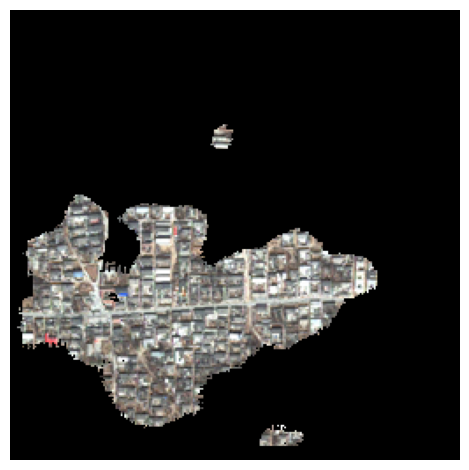

In [9]:
import torch
from utils import *
from models import *
from geoconfig import config
import cv2
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

# cmap =cm.get_cmap("seismic")
# cmap =cm.get_cmap("jet")
cmap =cm.get_cmap("binary")

model_dir = config.TRAIN.model_dir
feature_num = 32
image_size = 256
D_num = 1
T_num = 3
refine = 1
FBSN = Feedback_saliency_generator(features = feature_num, D = D_num, T_int = T_num,if_refine = refine).cuda()
def load_model(model, path):
    #  restore models
    model.load_state_dict(torch.load(path+'best weights.pth'))
load_model(FBSN, model_dir)

def toTensor(img):
    assert type(img) == np.ndarray,'the img type is {}, but ndarry expected'.format(type(img))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    #return img.float().div(255).unsqueeze(0)  # 255也可以改为25
    return img.unsqueeze(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

im = np.array(cv2.resize(cv2.imread(os.path.join('../../data/geoeye-1/haze/APFFdehaze/train/residential/', '5_7_1.tif')), (image_size, image_size)), np.float32) / 255.               
# im = np.array(cv2.resize(cv2.imread(os.path.join('../../data/spot5/haze/test/', '3_4_13.tif')), (image_size, image_size)), np.float32) / 255.
# im = np.array(cv2.resize(cv2.imread(os.path.join('../../data/spot5/nonuni_haze/APFFdehaze/test/', '2_9_22.tif')), (image_size, image_size)), np.float32) / 255.
# im = np.array(cv2.resize(cv2.imread(os.path.join('../../data/geoeye-1/deep_haze/AODdehaze/test/', '3_18_67.tif')), (image_size, image_size)), np.float32) / 255.

test_x_tensor = toTensor(im)
#print(test_x_tensor.shape) #[1, 3, 256, 256]
test_x_tensor = Variable(torch.as_tensor(test_x_tensor, dtype=torch.float32))
test_x_tensor = test_x_tensor.to(device)
output = FBSN(test_x_tensor)

sa = output[-1].cpu() #[1, 2, 256, 256]
sa = sa.detach().numpy()  # (1, 2, 256, 256)
sa = np.array(sa)
sa = np.squeeze(sa)[0, :, :] #(256,256)
sa_image = sa
sgt = (255*(sa_image-sa_image.min())/(sa_image.max()-sa_image.min())).astype(np.uint8)
thr, sgt = cv2.threshold(sgt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

img = np.asarray(Image.open(os.path.join('../../data/geoeye-1/geo_train/train/residential/', '5_7_1.tif')).resize((256, 256), Image.Resampling.LANCZOS))
# img = np.asarray(Image.open(os.path.join('../../data/geoeye-1/geo_test/img/', '3_18_67.tif')).resize((256, 256), Image.Resampling.LANCZOS))
# img = np.asarray(Image.open(os.path.join('../../data/spot5/spot5_test/img/', '2_9_22.tif')).resize((256, 256), Image.Resampling.LANCZOS))

smap = (255*(cmap(sgt)[:,:,:3]))
smap = (smap+img)
smap[smap>255]=0
smap = smap.astype(np.uint8)

plt.imshow(smap); plt.axis('off'); plt.tight_layout(); plt.show()